In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Use seaborn's default style to make beautifull graphs

import pandas as pd
import numpy as np

import folium
from geopy.geocoders import Nominatim

In [3]:
emdat_data = pd.read_excel("data/public_emdat_incl_hist_2024-03-26.xlsx")
#emdat_data = pd.read_csv(f"updated_emdat_data.csv")

In [4]:
emdat_data.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'Total Damage ('000 US$)', 'Total Damage, Adjusted ('000 US$)', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update'],
      dtype='object')

In [5]:
# If multiple countries are affected, each will have an entry linked to the same Dis No.
emdat_data["Country"].unique()

array(['United States of America', 'Jamaica', 'Japan', 'Türkiye', 'India',
       'Cabo Verde', 'Uganda', 'Belgium', 'Guatemala', 'Myanmar',
       'Martinique', 'Saint Vincent and the Grenadines', 'Soviet Union',
       'China', 'Canada', 'France', 'Comoros', 'Israel',
       'Iran (Islamic Republic of)', 'Niger', 'Bangladesh',
       'Taiwan (Province of China)', 'Greece', 'Italy', 'Philippines',
       'Albania', 'Colombia', 'Chile',
       'China, Hong Kong Special Administrative Region',
       'United Kingdom of Great Britain and Northern Ireland', 'Germany',
       'Romania', 'Indonesia', 'Mexico', 'Haiti', 'Morocco', 'Portugal',
       'Pakistan', 'Costa Rica', 'Algeria', 'Burkina Faso', 'Gambia',
       'Guinea-Bissau', 'Mali', 'Mauritania', 'Senegal', 'Chad',
       'Kazakhstan', 'Spain', 'Peru', 'Tokelau', 'Belarus', 'Bulgaria',
       'Netherlands (Kingdom of the)', 'Denmark', 'Puerto Rico',
       'New Zealand', 'Anguilla', 'Germany Federal Republic', 'Argentina',
       '

In [6]:
emdat_data["Subregion"].unique() 

array(['Northern America', 'Latin America and the Caribbean',
       'Eastern Asia', 'Western Asia', 'Southern Asia',
       'Sub-Saharan Africa', 'Western Europe', 'South-eastern Asia',
       'Eastern Europe', 'Southern Europe', 'Northern Europe',
       'Northern Africa', 'Central Asia', 'Polynesia',
       'Australia and New Zealand', 'Melanesia', 'Micronesia'],
      dtype=object)

In [7]:
emdat_data["Region"].unique()

array(['Americas', 'Asia', 'Africa', 'Europe', 'Oceania'], dtype=object)

In [8]:
emdat_data["Location"] , len(emdat_data["Location"].unique())

(0                                        Galveston (Texas)
 1                                 Hoboken, New York, Piers
 2                                              Saint James
 3                                                    Porus
 4                                                      NaN
                                ...                        
 26438                                                Dakha
 26439                                                  NaN
 26440              Between Santa Rosa de Copan and Gracias
 26441                                      Niéna-Koumantou
 26442    Boyaca, Cordoba, Cundinamarca, Huila, Santande...
 Name: Location, Length: 26443, dtype: object,
 20361)

Text(0.5, 1.0, 'Percentage of missing values in each column')

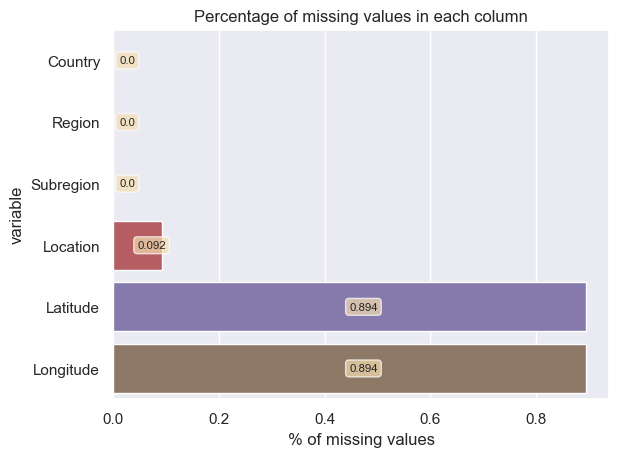

In [9]:
columns = ["Country","Region","Subregion","Location","Latitude","Longitude"]

fig, ax = plt.subplots()
sns.barplot(pd.DataFrame(emdat_data[columns].isna().mean()).reset_index().rename(columns={"index":"variable", 0:"% of missing values"}), y="variable", x="% of missing values", ax=ax, hue="variable", legend=False)
for i in ax.containers:
    ax.bar_label(
        i,
        fmt="{:.3}",
        label_type="center",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.7),
        padding=10,
        fontsize="x-small",
    )
# set title
ax.set_title("Percentage of missing values in each column")

We almost don't have longitude and latitulde information, so start by using the disasters that have it
Then use locations columns, to obtain that info
Then if neither location use the country information with location at the center

Good idea to already preprocces all that data before, like add it to a our version of the data, to avoid the need to run when loading the page

In [10]:
# Function to geocode location names to latitude and longitude
def geocode_location(location,geolocator,extra_info=None):
    try:

        if extra_info:
            query = f"{extra_info},{location}"
        else:
            query = f"{location}"
        print(query)
        location = geolocator.geocode(query)

        if location:
            print(f"Geocoded {query} to {location.latitude}, {location.longitude}")
            return location.latitude, location.longitude
        else:
            print(f"Could not geocode {location}")
            return None, None
    except Exception as e:
        print(f"Error geocoding {location}: {str(e)}")
        return None, None

def geocode_locations_and_update(data, info="Location"):    
    # Initialize a geocoder
    geolocator = Nominatim(user_agent="my_geocoder")

    # Apply geocoding to locations with missing latitude and longitude
    missing_coords = data[data['Latitude'].isna() | data['Longitude'].isna()]
    total_missing = len(missing_coords)
    print(f"Total missing locations to geocode: {total_missing}")

    # Set 'Coordinates Specific' 
    data.loc[data.index.difference(missing_coords.index), 'Coordinates Specific'] = True

    # Reset progress counter
    progress_counter = 0

    # Save interval
    save_interval = 1000
    save_counter = 0

    # Apply geocoding and track progress
    for index, row in missing_coords.iterrows():

        # Geocode location
        latitude, longitude = geocode_location(row[info], geolocator)

        # Update latitude and longitude in DataFrame
        data.at[index, 'Latitude'] = latitude
        data.at[index, 'Longitude'] = longitude

        if info == "Location":
            data.at[index, 'Coordinates Specific'] = True
        else:
            data.at[index, 'Coordinates Specific'] = False

        # Update progress
        progress_counter += 1
        print(f"Progress: {progress_counter}/{total_missing} ({(progress_counter/total_missing)*100:.2f}%), Info get: {latitude}, {longitude}")

        # Check if it's time to save the data
        if progress_counter % save_interval == 0:
            print("Saving progress...")
            # Concatenate with existing data and save to CSV
            data.to_csv(f'updated_emdat_data_{save_counter}.csv', index=False)

            # Increment save counter
            save_counter += 1

    # Save the final updated data to a new CSV file
    data.to_csv('updated_emdat_data_test.csv', index=False)

In [ ]:
"""import requests
import numpy as np

def get_lat_lon_from_address(address: str, country: str = None) -> tuple:
    try:
        if country:
            query = f"{address}, {country}"
        else:
            query = f"{address}"
        url = f'https://nominatim.openstreetmap.org/search?q={query}&format=json'
        response = requests.get(url).json()

        if len(response) > 0 :
            latitude = float(response[0]['lat'])
            longitude = float(response[0]['lon'])
            print(f"Geocoded {query} to {latitude}, {longitude}")
            return latitude, longitude
        else:
            print(f"Could not geocode {query}")
            return np.nan, np.nan
    except Exception as e:
        print(f"Error geocoding {query}: {str(e)}")
        return np.nan, np.nan"""

In [16]:
# Check the number of missing locations of the cvs file
data = pd.read_csv(f"4_emdat_data_all_coord.csv")

# rename country names to match the geopy geocoder
# Replace country names to match the geopy geocoder
#data.replace({"Country": { "Taiwan (Province of China)": "Taiwan", "People's Democratic Republic of Yemen": "Yemen", "Yemen Arab Republic": "Yemen"}}, inplace=True)

missing_coords = data[data['Latitude'].isna() | data['Longitude'].isna()]
total_missing = len(missing_coords)
print(f"Original total missing locations to geocode: {total_missing}")

# Geocode the missing locations

#geocode_locations_and_update(data, info = "Country")
#geocode_locations_and_update(data, info= "Location")

missing_coords["Country"]

Original total missing locations to geocode: 0


Series([], Name: Country, dtype: object)

In [19]:
data["Disaster Group"].unique()

array(['Natural', 'Technological'], dtype=object)

In [20]:
# Drop technological disasters
print("all",len(data))
data = data[data["Disaster Group"] != "Technological"]
len(data)

all 26443


17002

In [22]:
# Create a map centered around a specific location
m = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()], zoom_start=2)

# Add markers for each disaster location
for index, row in data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Location'],icon=folium.Icon(icon='info-sign', prefix='glyphicon')).add_to(m)

# Save the map to an HTML file
m.save('disaster_map.html')

In [23]:
from folium.plugins import MarkerCluster

# Create a map centered around a specific location
m = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()], zoom_start=2)

# Initialize a MarkerCluster object
marker_cluster = MarkerCluster().add_to(m)

# Add markers for each disaster location to the MarkerCluster
for index, row in data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Location'], icon=folium.Icon(icon='info-sign', prefix='glyphicon')).add_to(marker_cluster)

# Save the map to an HTML file
m.save('disaster_map_clustered.html')
